In [54]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [81]:
def grid(n, m, l):
    grid = [[i, j, k] for i in range(n) for j in range(m) for k in range(l)]
    grid = np.array(grid)
    grid = grid*2/ np.array([n, m, l]) - np.array([1, 1, 1])
    grid += np.array([1, 1, 1])/np.array([n, m, l])
    return grid

def PBC_distances(positions):
    N = positions.shape[0]
    result = np.array([positions]*positions.shape[0])
    result = result - result.transpose(1, 0, 2)
    result = (result + 1)%2 - 1
    return result

def PBC_forces(positions, eps, sigma):
    dist = PBC_distances(positions)
    d_norm = np.linalg.norm(dist, axis = 2)
    d_norm = np.where(d_norm == 0, np.inf, d_norm)
    F = 24*eps/(d_norm**2)*(2*(sigma/d_norm)**12 - (sigma/d_norm)**6)
    F = np.transpose(np.array([F]*3), axes = (1, 2, 0))
    F = -F*dist
    F = F.sum(axis = 1)
    return F

def U_LJ(positions, eps, sigma):
    dist = PBC_distances(positions)
    d_norm = np.linalg.norm(dist, axis = 2)
    d_norm = np.where(d_norm == 0, np.inf, d_norm)
    sixth_p = (sigma/d_norm)**6
    U = 4*eps*(sixth_p**2 - sixth_p)
    U_total = U.sum()
    return U_total

In [85]:
class system:
    def __init__(self, N, sigma = 0.05, eps = 0.05):
        self.N = N
        self.sigma = sigma
        self.eps = eps
        self.n = int(np.cbrt(N))
        self.positions = grid(self.n, self.n, self.n)
        self.N = self.n**3
        self.v = np.random.rand(self.N, 3)
        self.v -= self.v.mean(axis=0)
        self.v = self.v/self.v.std(axis=0)

        self.initial_positions = grid(self.n, self.n, self.n)

    def run(self, dt, steps):
        self.prev_positions, self.positions = self.positions, (self.positions + self.v*dt)
        KE, PE = np.zeros(steps), np.zeros(steps)
        p = np.zeros((steps, 3))
        i = 0
        v_log = np.zeros((steps, self.N, 3))
        MSD = np.zeros(steps)
        while i!= steps:
            forces = PBC_forces(self.positions, self.eps, self.sigma)
            new_positions = 2 * self.positions - self.prev_positions + forces * dt**2
            self.v = (new_positions - self.prev_positions) /(2 * dt)
            self.prev_positions, self.positions = self.positions, new_positions
            KE[i] = np.sum(self.v**2)
            PE[i] = U_LJ(self.positions, self.eps, self.sigma)
            v_log[i] = self.v
            p[i] = np.sum(self.v)
            MSD[i] = np.mean(np.power(np.linalg.norm(self.positions - self.initial_positions, axis = 1), 2))
            i += 1

        return self.positions, KE, PE, v_log, p, MSD

In [119]:
s = system(512)
dt = 0.001
positions, KE, PE, v_log, p, MSD = s.run(dt, 500)

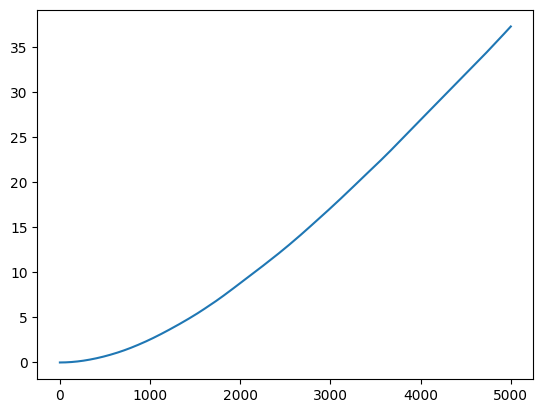

In [96]:
plt.plot(MSD)
k, b = np.polyfit(np.arange(24500, 25000), MSD[24500:25000], 1)

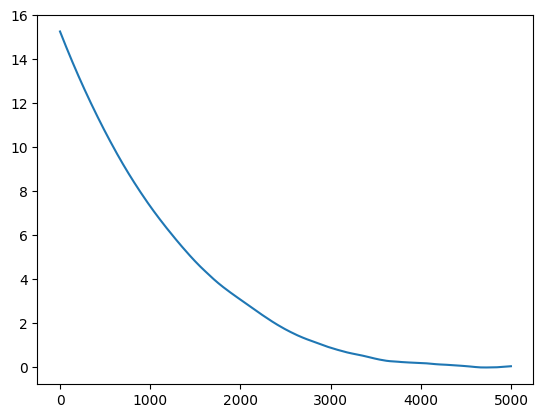

In [97]:
plt.plot(MSD - k*np.arange(5000) - b)

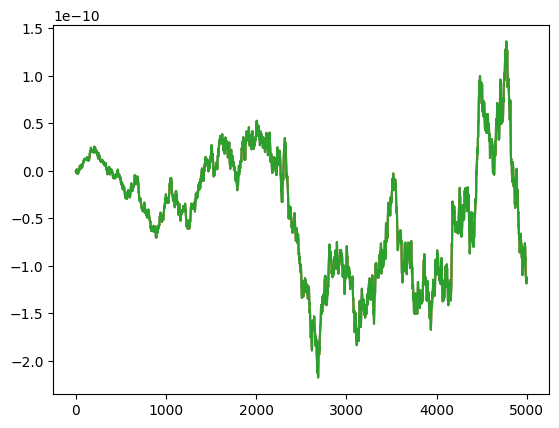

In [58]:
plt.plot(p)

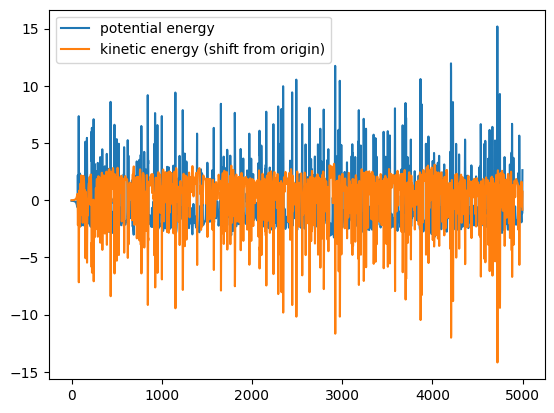

In [74]:
plt.plot(PE, label = "potential energy")
plt.plot(KE - 3*s.N, label = "kinetic energy (shift from origin)")
#plt.xlim(100, 200)
plt.legend()

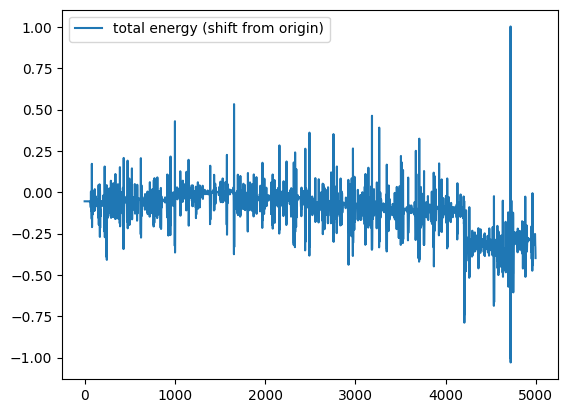

In [77]:
plt.plot(KE[1:] + PE[:-1] - 3*s.N, label = "total energy (shift from origin)")
plt.legend()

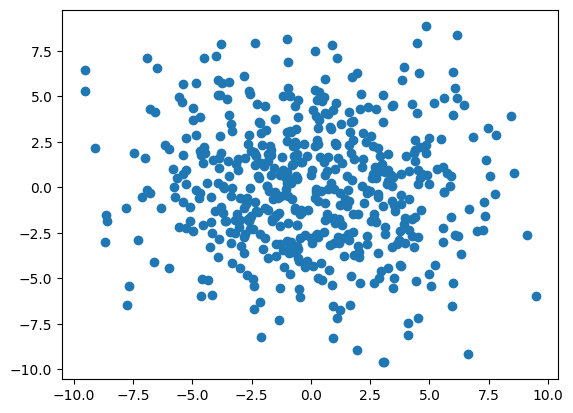

In [61]:
plt.scatter(s.positions[:, 0], s.positions[:, 1])

In [62]:
#kT/m = 1

def f(v):
    return (2*np.pi)**(-3/2)*4*np.pi*np.power(v, 2)*np.exp(-np.power(v, 2)/2)

(array([11., 21., 27., 50., 40., 49., 65., 70., 42., 30., 29., 22., 22.,
        13.,  3.,  5.,  8.,  3.,  1.,  1.]),
 array([0.27662557, 0.46063801, 0.64465045, 0.8286629 , 1.01267534,
        1.19668778, 1.38070023, 1.56471267, 1.74872511, 1.93273755,
        2.11675   , 2.30076244, 2.48477488, 2.66878732, 2.85279977,
        3.03681221, 3.22082465, 3.40483709, 3.58884954, 3.77286198,
        3.95687442]),
 <BarContainer object of 20 artists>)

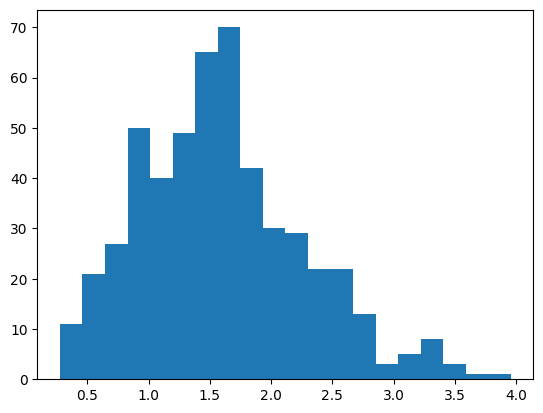

In [63]:
plt.hist(np.linalg.norm(s.v, axis = 1), bins = 20)

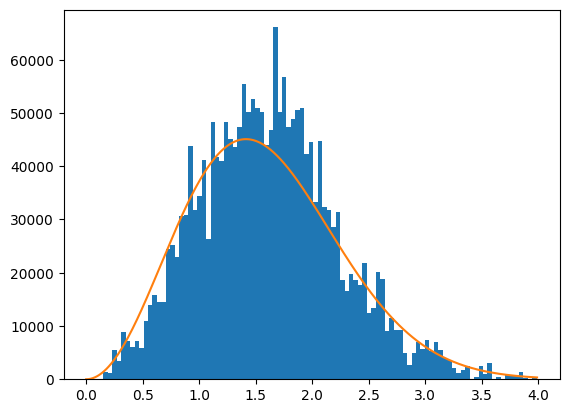

In [64]:
bins = 100
plt.hist(np.linalg.norm(v_log[1000:], axis = 2).flatten(), bins = bins)
plt.plot(np.arange(0, 4, 0.01), f(np.arange(0, 4, 0.01))*s.N*5000/bins*3)

In [71]:
PBC_forces(s.positions, s.eps, s.sigma), U_LJ(s.positions, s.eps, s.sigma)

(array([[ 1.13143313e-01, -8.20738174e-02, -3.16271701e-01],
        [ 7.51728612e-03,  1.30327003e-03,  1.70547774e-02],
        [-8.80195614e-03, -1.00563950e-02, -8.61581432e-03],
        ...,
        [-1.28117332e-03,  1.67055780e-03, -4.08880219e-04],
        [ 4.32058497e-03,  1.16075732e-03, -3.36039040e-03],
        [-2.53212732e-04,  1.53428180e-03,  1.60616019e-04]]),
 2.6271918387218935)

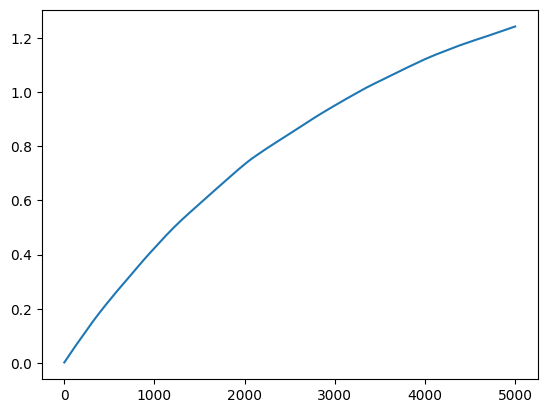

In [103]:
D_ES = MSD/(6*0.001*(np.arange(MSD.size) + 1))
plt.plot(D_ES)

In [114]:
D_GK = np.sum(np.multiply(np.mean(np.multiply(v_log, v_log[0]), axis=(1, 2))*0.001, np.exp(-np.arange(v_log.shape[0])/2000)))